Librerias

In [3]:
import sys
import re
import xml.etree.ElementTree as ET
import json
import time
import numpy as np
from geniatagger import GeniaTagger
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_infix_regex
import nltk
from nltk.corpus import stopwords                
from nltk.tokenize import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from gensim.models.keyedvectors import KeyedVectors
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
import keras.backend as K

plt.style.use('ggplot')
word_vectors_model = KeyedVectors.load_word2vec_format('data/pubmed_word_embeddings/PubMed-w2v.bin', binary=True)
tagger = GeniaTagger('C:\\Users\\jonat\\Desktop\\respaldo\\python\\pruebas_genia\\geniatagger-3.0.2\\geniatagger')
nlp = spacy.load("en_core_web_sm")

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Personalización de libreria spacy  para aceptar textos con "-"

In [4]:
def custom_tokenizer(nlp):
    inf = list(nlp.Defaults.infixes)               # Default infixes
    inf.remove(r"(?<=[0-9])[+\-\*^](?=[0-9-])")    # Remove the generic op between numbers or between a number and a -
    inf = tuple(inf)                               # Convert inf to tuple
    infixes = inf + tuple([r"(?<=[0-9])[+*^](?=[0-9-])", r"(?<=[0-9])-(?=-)"])  # Add the removed rule after subtracting (?<=[0-9])-(?=[0-9]) pattern
    infixes = [x for x in infixes if '-|–|—|--|---|——|~' not in x] # Remove - between letters rule
    infix_re = compile_infix_regex(infixes)

    return Tokenizer(nlp.vocab, prefix_search=nlp.tokenizer.prefix_search,
                                suffix_search=nlp.tokenizer.suffix_search,
                                infix_finditer=infix_re.finditer,
                                token_match=nlp.tokenizer.token_match,
                                rules=nlp.Defaults.tokenizer_exceptions)

nlp.tokenizer = custom_tokenizer(nlp)


Función para la extracción de datos de los corpus en XML

In [ ]:
def process_xml_file_json(fname , outfname):
    tree = ET.parse(fname)
    root = tree.getroot()
    documentos =[]
    
    #find all pairs and write then out one per file in kelp format
    for pair in root.findall( './document/sentence/pair' ):	
        pairid = pair.attrib['id']
        pairLabel  = pair.attrib['interaction']
        e1id = pair.attrib['e1']
        e2id = pair.attrib['e2'] #like AIMed.d0.s5.e2
        sentenceId =  e1id[ 0 :  e1id.rfind(".")  ]  #contained as part of entity id

        sentLst =  root.findall('./document/sentence/[@id="' +sentenceId+ '"]')
        rawText = sentLst[0].attrib['text']
        #if len(sentLst) != 1 : 
        #    print >>sys.stderr, "multiple sentences for sentence id ", sentenceId
        #    sys.exit(-1)
        #    rawText = sentLst[0].attrib['text']

        #next find the entity's character offset-span
        ent1Lst = root.findall('./document/sentence/entity[@id="' +e1id+  '"]')	
        ent2Lst = root.findall('./document/sentence/entity[@id="' +e2id+  '"]')	
        if len(ent1Lst)!=1 or len(ent2Lst)!=1 :
            print >>sys.stderr, "multiple entity elements for ", e1id, e2id
            sys.exit(-1)

        e1Span = ent1Lst[0].attrib['charOffset']
        e2Span = ent2Lst[0].attrib['charOffset']
        e1Text = ent1Lst[0].attrib['text']
        e2Text = ent2Lst[0].attrib['text']

        ## add if posible, sentenceId, e1start, e1end (look in charspan)
        #rename entity1Text  to entity1Details - same for entity2
        try : #if span contains "," .. ie multiple char spans.. just take the first one - helpless
            tarr = e1Span.split(",")[0].split("-")
            e1start, e1end = int(tarr[0]), int(tarr[1])
            tarr = e2Span.split(",")[0].split("-")
            e2start, e2end = int(tarr[0]), int(tarr[1])
        except:
            print >>sys.stderr, "problem in parsing ", e1Span, e2Span
            sys.exit(-1)

        datos = {
            "pairLabel":pairLabel,
            "pairid":pairid,
            "sentence": rawText,
            "sentenceId":sentenceId,
            "entity1":e1id,
            "entity2":e2id,
            "entity1Details":e1Text,
            "entity2Details":e2Text,
            "e1start":e1start,
            "e1end":e1end,
            "e2start":e2start,
            "e2end":e2end
        }
    
    
        documentos.append(datos)
    
    ########
    with open(outfname, 'w') as outfile:
        json.dump(documentos, outfile)
    print(sys.stderr, "done with ", fname)

In [ ]:
fname = "data/ppi_data/AImed-learning-format.xml"
outfname = "data/ppi_data/AImed-learning-format-json.txt"
process_xml_file_json(fname , outfname)

In [5]:
documentos = []

with open('data/ppi_data/AImed-learning-format-json.txt') as json_file:
    documentos = json.load(json_file)
    
print("Numero de documentos :"+ str(len(documentos)))

Numero de documentos :5834


Creación de diccionario de palabras

In [6]:
tic = time.perf_counter()

text_list=[]

for i in documentos:
    text = re.sub("[^a-zA-Z-0-9]"," ",i["sentence"])
    text = text.lower()
    text = nltk.word_tokenize(text)
    text=" ".join([w for w in text if len(w)>1]) 
    geniatex = tagger.parse(text)
    sptex = nlp(text)
    datos = {
            "pairLabel":i["pairLabel"],
            "sentence": text,
            "genia":geniatex,            
            "spacy":sptex,
            "entity1Details":i["entity1Details"],
            "entity2Details":i["entity2Details"],
            "e1start":i["e1start"],
            "e1end":i["e1end"],
            "e2start":i["e2start"],
            "e2end":i["e2end"]
        }
    
    text_list.append(datos)


toc = time.perf_counter()
print(f"implementación de genia y spacy en {toc - tic:0.4f} segundos")

implementación de genia y spacy en 110.6576 segundos


In [5]:
def indexdx(genia_text, prot, pos):
    idx = 0
    for enum,i in enumerate(genia_text):
        if i[0] == prot:
            idx = enum
            break
    return idx - pos

In [6]:
tic = time.perf_counter()
datos_tex = []
textos_idx = []
for i in text_list:
    id_tex = []
    for idx,j in enumerate(i["genia"]):
        if  j[0] == i["entity1Details"].lower():
            if i["pairLabel"] == "True":
                datos = (j[0],j[2],j[3],"PROT1",i["spacy"][idx].dep_ , indexdx(i["genia"], i["entity1Details"].lower(), idx) , indexdx(i["genia"], i["entity2Details"].lower(), idx))
                if datos not in datos_tex:
                    datos_tex.append(datos)
                    id_tex.append(len(datos_tex) - 1)
                else:
                    id_tex.append(datos_tex.index(datos))
            else:
                datos = (j[0],j[2],j[3],"PROT",i["spacy"][idx].dep_ , indexdx(i["genia"], i["entity1Details"].lower(), idx) , indexdx(i["genia"], i["entity2Details"].lower(), idx))
                if datos not in datos_tex:
                    datos_tex.append(datos)
                    id_tex.append(len(datos_tex) - 1)
                else:
                    id_tex.append(datos_tex.index(datos))
        elif  j[0] == i["entity2Details"].lower():
            if i["pairLabel"] == "True":
                datos = (j[0],j[2],j[3],"PROT2",i["spacy"][idx].dep_ , indexdx(i["genia"], i["entity1Details"].lower(), idx) , indexdx(i["genia"], i["entity2Details"].lower(), idx))
                if datos not in datos_tex:
                    datos_tex.append(datos)
                    id_tex.append(len(datos_tex) - 1)
                else:
                    id_tex.append(datos_tex.index(datos))
            else:
                datos = (j[0],j[2],j[3],"PROT",i["spacy"][idx].dep_ , indexdx(i["genia"], i["entity1Details"].lower(), idx) , indexdx(i["genia"], i["entity2Details"].lower(), idx))
                if datos not in datos_tex:
                    datos_tex.append(datos)
                    id_tex.append(len(datos_tex) - 1)
                else:
                    id_tex.append(datos_tex.index(datos))
        else:
            datos = (j[0],j[2],j[3],"O",i["spacy"][idx].dep_ , indexdx(i["genia"], i["entity1Details"].lower(), idx) , indexdx(i["genia"], i["entity2Details"].lower(), idx))
            if datos not in datos_tex:
                datos_tex.append(datos)
                id_tex.append(len(datos_tex) - 1)
            else:
                id_tex.append(datos_tex.index(datos))
    textos_idx.append(id_tex)

toc = time.perf_counter()
print(f"creación de diccionario y tokenización de texto en {toc - tic:0.4f} segundos")

creación de diccionario y tokenización de texto en 640.9014 segundos


In [7]:
outfname = "data/ppi_data/AImed-diccionario-listado.txt"

with open(outfname, 'w') as outfile:
        json.dump(datos_tex, outfile)

outfname = "data/ppi_data/AImed-tokenizado.txt"

with open(outfname, 'w') as outfile:
        json.dump(textos_idx, outfile)

In [8]:
datos_tex

[('cytokines', 'NNS', 'B-NP', 'O', 'nsubj', 3, 11),
 ('measurements', 'NNS', 'I-NP', 'O', 'dobj', 2, 10),
 ('during', 'IN', 'B-PP', 'O', 'prep', 1, 9),
 ('ifn-alpha', 'NN', 'B-NP', 'PROT', 'amod', 0, 8),
 ('treatment', 'NN', 'I-NP', 'O', 'pobj', -1, 7),
 ('showed', 'VBD', 'B-VP', 'O', 'ROOT', -2, 6),
 ('trend', 'NN', 'B-NP', 'O', 'dobj', -3, 5),
 ('to', 'TO', 'B-PP', 'O', 'prep', -4, 4),
 ('decreasing', 'VBG', 'B-VP', 'O', 'amod', -5, 3),
 ('levels', 'NNS', 'B-NP', 'O', 'pobj', -6, 2),
 ('of', 'IN', 'B-PP', 'O', 'prep', -7, 1),
 ('il-4', 'NN', 'B-NP', 'PROT', 'pobj', -8, 0),
 ('at', 'IN', 'B-PP', 'O', 'prep', -9, -1),
 ('12', 'CD', 'B-NP', 'O', 'nummod', -10, -2),
 ('and', 'CC', 'I-NP', 'O', 'cc', -11, -3),
 ('24', 'CD', 'I-NP', 'O', 'conj', -12, -4),
 ('weeks', 'NNS', 'I-NP', 'O', 'pobj', -13, -5),
 ('levels', 'NNS', 'B-NP', 'O', 'nsubjpass', 2, 7),
 ('of', 'IN', 'B-PP', 'O', 'prep', 1, 6),
 ('ifn-gamma', 'NN', 'B-NP', 'PROT', 'pobj', 0, 5),
 ('were', 'VBD', 'B-VP', 'O', 'auxpass', -1

In [ ]:
datos_tex = []
textos_idx = []

outfname = "data/ppi_data/AImed-diccionario-listado.txt"
with open(outfname) as json_file:
    datos_tex = json.load(json_file)
    
outfname = "data/ppi_data/AImed-tokenizado.txt"
with open(outfname) as json_file:
    textos_idx = json.load(json_file)

In [11]:
word_index = []
for i in datos_tex:
    if i[0] not in word_index:
        word_index.append(i[0])
print("total palabras corpus: "+ str(len(word_index)))

total palabras corpus: 4318


In [23]:
#textos_idx_ngram = []
datos_tex_ngram = []

#matrix_ngram = np.zeros((vocab_size, embedding_dim))
#doc_ngram= np.zeros(len(word_index))
for i in text_list:
    for idx,j in enumerate(i["spacy"]):
        if j.dep_ == "ROOT":
            datos = (j.text, j.dep_)
            datos_tex_ngram.append(datos)
        else:
            datos = (j.text, j.head.text)
            datos_tex_ngram.append(datos)

print("datos ngram",len(datos_tex_ngram))

In [24]:
diccionario_ngram = []
for i in datos_tex_ngram:
    if i not in diccionario_ngram:
        #print("no esta",i)
        diccionario_ngram.append(i) 

print("diccionario ngram",len(diccionario_ngram))

diccionario ngram 17548


In [28]:
texto_token_ngram = []
for i in text_list:
    textos_dngram = []
    for idx,j in enumerate(i["spacy"]):
        if j.dep_ == "ROOT":
            datos = (j.text, j.dep_)
            textos_dngram.append(diccionario_ngram.index(datos))
        else:
            datos = (j.text, j.head.text)
            textos_dngram.append(diccionario_ngram.index(datos))
    texto_token_ngram.append(textos_dngram)

print("texto token ngram",len(texto_token_ngram) )

texto token ngram 5834


In [30]:
outfname = "data/ppi_data/AImed-diccionario-listado_ngram.txt"

with open(outfname, 'w') as outfile:
        json.dump(diccionario_ngram, outfile)

outfname = "data/ppi_data/AImed-tokenizado_ngram.txt"

with open(outfname, 'w') as outfile:
        json.dump(texto_token_ngram, outfile)

In [38]:
tic = time.perf_counter()
emb_ngram = np.zeros((len(diccionario_ngram), len(word_index)+1))


for idx, i in enumerate(diccionario_ngram):
    bit_ngram = np.zeros(len(word_index)+1)
    
    try:
        palabra_ngram = word_index.index(i[1])
    except:
        palabra_ngram = -1
        
    if i[1] == "ROOT":
        bit_ngram[len(bit_ngram) - 1] = 1
    else:
        bit_ngram[palabra_ngram] = 1
    
    emb_ngram[idx] = bit_ngram

toc = time.perf_counter()
print(f"creación de matriz embedding ngram en {toc - tic:0.4f} segundos")    

creación de matriz embedding ngram en 0.7969 segundos


In [40]:
emb_ngram.shape

(17548, 4319)

Creación matriz embbeding

In [41]:
def bitPOS(pos):
    listado =  [["NN","NNS","NNP","NNPS"],
    ["VB","VBD","VBG","VBN","VBP","VBZ"],
    ["TO","IN","CC","LS"],
    ["RB","RBR","RBS","JJ","JJR","JJS","DT", "PDT","MD","JJ|NN"],
    ["WDT","WP","WP$","WRB","EX"],
    ["PRP","PRP$"],
    ["POS","RP","FW"],
    ["CD"]]
    listadobit = np.zeros(8)
    try:
        i = 0
        validar = False
        for ix, x in enumerate(listado):
            if(pos in x):
                i =  ix
                validar = True
                break
        if(validar ==  True):
            listadobit[i] = 1
    except:
        listadobit = np.zeros(8)
    return np.array(listadobit)

def bitChunk(chunk):
    listado =  {'O': 0,
 'B-PP': 1,
 'I-PP': 2,
 'I-ADJP': 3,
 'B-SBAR': 4,
 'I-VP': 5,
 'B-NP': 6,
 'I-NP': 7,
 'B-PRT': 8,
 'I-ADVP': 9,
 'I-SBAR': 10,
 'I-CONJP': 11,
 'B-VP': 12,
 'B-ADVP': 13,
 'B-CONJP': 14,
 'B-ADJP': 15}
    
    listadobit = np.zeros(18)
    try:
        i = 0
        validar = False
        if chunk in list(listado):
            validar = True
        if(validar ==  True):
            listadobit[listado[chunk]] = 1
    except:
        listadobit = np.zeros(18)
    return np.array(listadobit)

def bitNameEntity(ne):
    listado = ["PROT1","PROT2","PROT","O"]
    listadobit = np.zeros(4)
    try:
        listadobit[listado.index(ne)] = 1
    except:
        listadobit[3] = 1
    return np.array(listadobit)

def bitDep(dep):
    listado =  {'ROOT': 0,
 'preconj': 1,
 'predet': 2,
 'cc': 3,
 'quantmod': 4,
 'nsubjpass': 5,
 'dobj': 6,
 'poss': 7,
 'npadvmod': 8,
 'case': 9,
 'advmod': 10,
 'intj': 11,
 'meta': 12,
 'acl': 13,
 'csubjpass': 14,
 'expl': 15,
 'punct': 16,
 'agent': 17,
 'nmod': 18,
 'prep': 19,
 'pcomp': 20,
 'attr': 21,
 'det': 22,
 'oprd': 23,
 'parataxis': 24,
 'nsubj': 25,
 'dep': 26,
 'nummod': 27,
 'pobj': 28,
 'appos': 29,
 'amod': 30,
 'advcl': 31,
 'conj': 32,
 'prt': 33,
 'dative': 34,
 'xcomp': 35,
 'csubj': 36,
 'mark': 37,
 'aux': 38,
 'neg': 39,
 'compound': 40,
 'auxpass': 41,
 'acomp': 42,
 'relcl': 43,
 'ccomp': 44}
    
    listadobit = np.zeros(101)
    try:
        i = 0
        validar = False
        if dep in list(listado):
            validar = True
        if(validar ==  True):
            listadobit[listado[dep]] = 1
    except:
        listadobit = np.zeros(101)
    return np.array(listadobit)

def bitDx(dx):
    sign = 0
    if dx < 0:
        sign = 1
        dx  = dx * (-1)
    if dx > 8:
        dx = 8
    
    listadobit = np.zeros(10)
    
    listadobit[0] = sign
    listadobit[dx + 1] = 1 
    
    return np.array(listadobit)

In [42]:
words =  word_vectors_model.index_to_key 
words  =  list(words)

print("total palabras PubMed-w2v: "+ str(len(words)))

total palabras PubMed-w2v: 2351706


In [43]:
tic = time.perf_counter()
vocab_size = len(datos_tex) 
embedding_dim = 351 # word embedding 200 + pos 8 + chunck 18 + nombre de la entidad 4 + depencia 101 + d1 10 + d2 10
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word in words:
    if word in word_index:
            word_idx = [idx for idx,x in enumerate(datos_tex) if x[0] == word ]
            for i in word_idx:
                #print(datos_tex[i])
                emb = np.array(word_vectors_model[word], dtype=np.float32)[:200]
                pos = bitPOS(datos_tex[i][1])
                chunk = bitChunk(datos_tex[i][2])
                ne = bitNameEntity(datos_tex[i][3])
                dep = bitDep(datos_tex[i][4])
                d1 = bitDx(datos_tex[i][5])                
                d2 = bitDx(datos_tex[i][6])
                total = np.concatenate((emb, pos), axis=None)            
                total = np.concatenate((total, chunk), axis=None)                
                total = np.concatenate((total, ne), axis=None)                
                total = np.concatenate((total, dep), axis=None)                
                total = np.concatenate((total, d1), axis=None)                
                total = np.concatenate((total, d2), axis=None)
                embedding_matrix[i] = total

toc = time.perf_counter()
print(f"creación de matriz embedding en {toc - tic:0.4f} segundos")

creación de matriz embedding en 222.7892 segundos


Creación datos de entrenamiento y pruebas

In [44]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento acc')
    plt.plot(x, val_acc, 'r', label='Validación acc')
    plt.title('Entrenamiento y validación de acc')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento loss')
    plt.plot(x, val_loss, 'r', label='Validación loss')
    plt.title('Entrenamiento y validación loss')
    plt.legend()
    
def plot_historyPR(history):
    acc = history.history['precision_m']
    val_acc = history.history['val_precision_m']
    loss = history.history['recall_m']
    val_loss = history.history['val_recall_m']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento precision')
    plt.plot(x, val_acc, 'r', label='Validación precision')
    plt.title('Entrenamiento y validación de precision')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento recall')
    plt.plot(x, val_loss, 'r', label='Validación recall')
    plt.title('Entrenamiento y validación recall')
    plt.legend()
    
    
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [49]:
def strbool(str):
    if str == 'False':
        return 0
    else:
        return 1
    
X = textos_idx
X_ngram = texto_token_ngram
y = [strbool(x["pairLabel"]) for x in text_list ]
y = np.array(y)


sentences_train = X[0:3500]
sentences_train_ngram = X_ngram[0:3500]
y_train = y[0:3500]

sentences_test = X[3501:len(X)]
sentences_test_ngram = X_ngram[3501:len(X)]
y_test = y[3501:len(X)]


maxlen =  160
X_train = pad_sequences(sentences_train, padding='post', maxlen=maxlen)
X_train_ngram = pad_sequences(sentences_train_ngram, padding='post', maxlen=maxlen)
X_test = pad_sequences(sentences_test, padding='post', maxlen=maxlen)
X_test_ngram = pad_sequences(sentences_test_ngram, padding='post', maxlen=maxlen)


#sentences_train, sentences_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

#sentences_train, sentences_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)
#maxlen =  160
#X_train = pad_sequences(sentences_train, padding='post', maxlen=maxlen)
#X_test = pad_sequences(sentences_test, padding='post', maxlen=maxlen)

In [51]:
!pip install pydot

In [54]:
!pip install graphviz

In [63]:
len_x = X_train.shape[1]
len_xngram = X_train_ngram.shape[1]

In [64]:
#channel 1 ngram

inputs1 = Input(shape=(len_xngram,))
embedding1 = layers.Embedding(len(diccionario_ngram), len(word_index)+1, 
                           weights=[emb_ngram], 
                           input_length=maxlen, 
                           trainable=True)(inputs1)
conv1 = layers.Conv1D(128, 5, activation='relu')(embedding1)
drop1 = layers.Dropout(0.5)(conv1)
pool1 = layers.GlobalMaxPool1D()(drop1)
flat1 = layers.Flatten()(pool1)

#channel 2

inputs2 = Input(shape=(len_x,))
embedding2 = layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True)(inputs2)
conv2 = layers.Conv1D(128, 5, activation='relu')(embedding2)
drop2 = layers.Dropout(0.5)(conv2)
pool2 = layers.GlobalMaxPool1D()(drop2)
flat2 = layers.Flatten()(pool2)


# merge
merged = concatenate([flat1, flat2])

# interpretation
dense1 = Dense(200, activation='relu')(merged)
dense2 = Dense(20, activation='relu')(dense1)
outputs = Dense(1, activation='sigmoid')(dense2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 160)]        0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 160, 4319)    75789812    input_11[0][0]                   
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 160, 351)     35630010    input_12[0][0]                   
____________________________________________________________________________________________

In [65]:
model.compile(optimizer=Adam(lr=0.007),
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m, precision_m, recall_m])


In [66]:
tic = time.perf_counter()

model.fit([X_train_ngram, X_train], y_train, batch_size=10, epochs=50, validation_split=0.2)

toc = time.perf_counter()
print(f"tiempo de entrenamiento y pruebas en {toc - tic:0.4f} segundos")

Epoch 1/50
280/280 [==============================] - 480s 2s/step - loss: 0.6191 - accuracy: 0.8398 - f1_m: 0.0074 - precision_m: 0.0044 - recall_m: 0.0221 - val_loss: 0.4930 - val_accuracy: 0.8086 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
280/280 [==============================] - 503s 2s/step - loss: 0.4440 - accuracy: 0.8426 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.4897 - val_accuracy: 0.8086 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
280/280 [==============================] - 499s 2s/step - loss: 0.4187 - accuracy: 0.8532 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.4916 - val_accuracy: 0.8086 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
280/280 [==============================] - 530s 2s/step - loss: 0.4265 - accuracy: 0.8480 - f1_m: 0.0000e+00 - precision_m: 0.00

280/280 [==============================] - 477s 2s/step - loss: 0.4423 - accuracy: 0.8385 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.4942 - val_accuracy: 0.8086 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 30/50
280/280 [==============================] - 580s 2s/step - loss: 0.4209 - accuracy: 0.8512 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.4924 - val_accuracy: 0.8086 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 31/50
280/280 [==============================] - 551s 2s/step - loss: 0.4410 - accuracy: 0.8394 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.4929 - val_accuracy: 0.8086 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 32/50
280/280 [==============================] - 540s 2s/step - loss: 0.4465 - accuracy: 0.8362 - f1_m: 0.0000e+00 - precision_m: 

In [67]:
# save the model
model.save('modelcnn2channel.h5')

In [71]:
# evaluate model on training dataset
#acc = model.evaluate([X_train_ngram, X_train], y_train, verbose=0)
loss, accuracy, f1_score, precision, recall = model.evaluate([X_train_ngram, X_train], y_train, verbose=False)
print('Train Accuracy: %f' % (accuracy*100))
 

Train Accuracy: 83.685714


In [72]:
# evaluate model on test dataset dataset
loss, accuracy, f1_score, precision, recall = model.evaluate([X_test_ngram, X_test], y_test, verbose=False)
print('Test Accuracy: %f' % (accuracy*100))

Test Accuracy: 81.611657


In [74]:
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8161


In [15]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.007),
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m, precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 160, 351)          35630010  
_________________________________________________________________
conv1d (Conv1D)              (None, 156, 128)          224768    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 35,856,079
Trainable params: 35,856,079
Non-trainable params: 0
____________________________________________

Training Accuracy: 0.9785
Training Precision: 0.8919
Training Recall: 1.0000
Training F1 Score: 0.9380
Testing Accuracy:  0.5456
Testing Precision:  0.2444
Testing Recall:  0.8885
Testing F1 Score:  0.3748


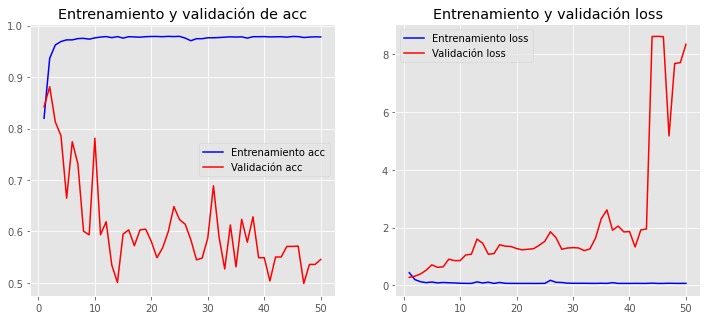

In [16]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy, f1_score, precision, recall = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Precision: {:.4f}".format(precision))
print("Training Recall: {:.4f}".format(recall))
print("Training F1 Score: {:.4f}".format(f1_score))

loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Precision:  {:.4f}".format(precision))
print("Testing Recall:  {:.4f}".format(recall))
print("Testing F1 Score:  {:.4f}".format(f1_score))
plot_history(history)

In [59]:
#prueba ngram
model = Sequential()
model.add(layers.Embedding(len(diccionario_ngram), len(word_index)+1, 
                           weights=[emb_ngram], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.007),
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m, precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 160, 4319)         75789812  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 156, 128)          2764288   
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 78,555,401
Trainable params: 78,555,401
Non-trainable params: 0
____________________________________________

Training Accuracy: 0.8369
Training Precision: 0.0000
Training Recall: 0.0000
Training F1 Score: 0.0000
Testing Accuracy:  0.8161
Testing Precision:  0.0000
Testing Recall:  0.0000
Testing F1 Score:  0.0000
tiempo de entrenamiento y pruebas en 34635.8736 segundos


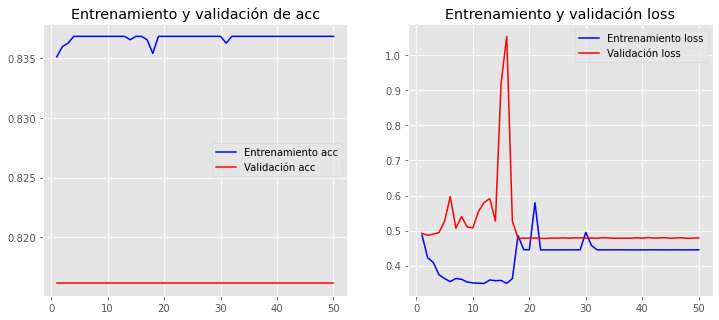

In [60]:
tic = time.perf_counter()
history = model.fit(X_train_ngram, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test_ngram, y_test),
                    batch_size=10)

loss, accuracy, f1_score, precision, recall = model.evaluate(X_train_ngram, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Precision: {:.4f}".format(precision))
print("Training Recall: {:.4f}".format(recall))
print("Training F1 Score: {:.4f}".format(f1_score))

loss, accuracy, f1_score, precision, recall = model.evaluate(X_test_ngram, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Precision:  {:.4f}".format(precision))
print("Testing Recall:  {:.4f}".format(recall))
print("Testing F1 Score:  {:.4f}".format(f1_score))
plot_history(history)


toc = time.perf_counter()
print(f"tiempo de entrenamiento y pruebas en {toc - tic:0.4f} segundos")